# Object Detection using Sliding Window

We will be using concepts like Image Pyramid, Sliding Window and Non-Maxima Supression to turn almost any Image Classifier into an Object Detector
* **Image Pyramid**: 
  * An image pyramid is a multi-scale representation of an image, allowing us to find objects in images at different scales of an image.
  * At the bottom of the pyramid, we have the original image at its original size (in terms of width and height).
  * And at each subsequent layer, the image is resized (subsampled) and optionally smoothed (usually via Gaussian blurring).
  * The image is progressively subsampled until some stopping criterion is met, which is normally when a minimum size has been reached and no further subsampling needs to take place.
* **Sliding Window**:
  * A sliding window is a fixed-size rectangle that slides from left-to-right and top-to-bottom within an image.
  * At each stop of the window we would:
    * Extract the ROI
    * Pass it through our image classifier
    * Obtain the output predictions
* **Non-Maxima Supression**:
  * When performing object detection, our object detector will typically produce multiple, overlapping bounding boxes surrounding an object in an image.
  * We somehow need to collapse/remove the extraneous bounding boxes.
  * Non-maxima suppression (NMS) collapses weak, overlapping bounding boxes in favor of the more confident ones.
  
**Credits**: [PyImageSearch](https://pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/)

In [1]:
%%capture
!pip install imutils

In [1]:
import numpy as np
import imutils
import os
import math
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.models import load_model
from matplotlib.patches import Rectangle
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt
import cv2

In [2]:
os.chdir('../')

In [3]:
with open('xtrain.npy','rb') as f:
    data = np.load('xtrain.npy')

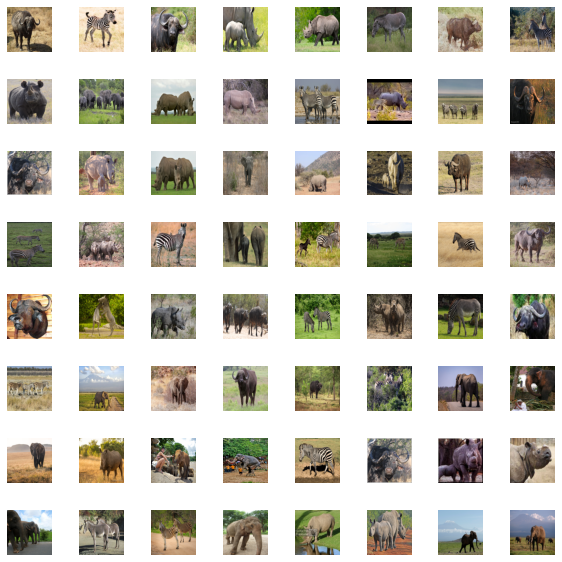

In [5]:
fig,axes = plt.subplots(8,8,figsize=(8,8))
fig.tight_layout(pad=0.1)
for i,ax in enumerate(axes.flat):
    randomindex = np.random.randint(1501)
    X_random = data[randomindex].reshape(224,224,3)
    ax.imshow(X_random,cmap="gray")
    ax.set_axis_off()

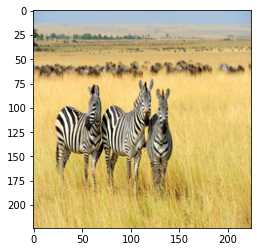

In [86]:
#5,666
orig = data[1500].reshape(224,224,3)
(H, W) = orig.shape[:2]
plt.imshow(orig, cmap='gray')

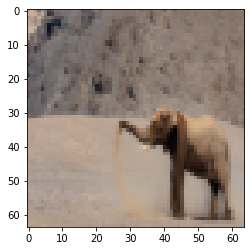

In [29]:
copy = resize(orig,(64,64),anti_aliasing=True)
plt.imshow(copy)

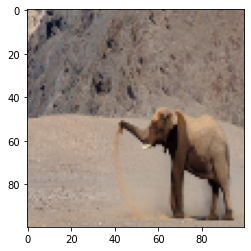

In [30]:
copy = cv2.resize(orig, (100,100))
plt.imshow(copy)

In [31]:
class SlidingWindowObjectDetection():
    def __init__(self, pretrained_classifier_path, **kwargs):
        self.model = load_model(pretrained_classifier_path)
        self.kwargs = kwargs
    
    def sliding_window(self, image, step, ws):
        for y in range(0, image.shape[0] - ws[1], step):
            for x in range(0, image.shape[1] - ws[0], step):
                yield (x, y, image[y:y + ws[1], x:x + ws[0]])

    def image_pyramid(self, image, scale=1.5, minSize=(224, 224)):
        yield image
        while True:
            w = int(image.shape[1] / scale)
            image = imutils.resize(image, width=w)
            if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
                break
            yield image   
            
    def get_rois_and_locs(self, pyramid):
        rois = []
        locs = []
        for image in pyramid:
            scale = W / float(image.shape[1])
            for (x, y, roiOrig) in self.sliding_window(image, self.kwargs['WIN_STEP'], self.kwargs['ROI_SIZE']):
                x = int(x * scale)
                y = int(y * scale)
                w = int(self.kwargs['ROI_SIZE'][0] * scale)
                h = int(self.kwargs['ROI_SIZE'][1] * scale)
                roi = cv2.resize(roiOrig, self.kwargs['INPUT_SIZE'])
                rois.append(roi)
                locs.append((x, y, x + w, y + h))
        return rois, locs
    
    def visualize_rois(self, rois):
        fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
        for ax, roi in zip(axes, rois):
            ax.imshow(roi, cmap='gray')
            
    def get_preds(self, rois, locs):
        rois = np.array(rois, dtype="float32")
        preds = self.model.predict(rois)
        preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
        labels = {}
        for (i, p) in enumerate(preds):
            (label, prob) = p
            if prob >= self.kwargs['MIN_CONF']:
                box = locs[i]
                L = labels.get(label, [])
                L.append((box, prob))
                labels[label] = L
        return preds, labels
    
    def apply_nms(self, labels):
        nms_labels = {}
        for label in sorted(labels.keys()):
            boxes = np.array([p[0] for p in labels[label]])
            proba = np.array([p[1] for p in labels[label]])
            boxes = non_max_suppression(boxes, proba)
            nms_labels[label] = boxes.tolist()
        return nms_labels
            
    def visualize_preds(self, img, nms_labels):
        for label in sorted(nms_labels.keys()):
            clone = img.copy()
            fig, ax = plt.subplots(figsize=(20, 6))
            boxes = nms_labels[label]
            for (startX, startY, endX, endY) in boxes:
                ax.add_patch(Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='red',facecolor='none',lw=1))
                y = startY - 10 if startY - 10 > 10 else startY + 10
                ax.text(startX,y,str(label),c='red')   
            ax.imshow(clone, cmap='gray')
            ax.set_axis_off()

In [76]:
kwargs = dict(
    PYR_SCALE=1.5,
    WIN_STEP=16,
    ROI_SIZE=(120, 120),
    INPUT_SIZE=(224, 224),
    VISUALIZE=True,
    MIN_CONF=0.98,
    VIZ_ROIS=True
)

In [77]:
model = SlidingWindowObjectDetection('models/wildlife.h5', **kwargs)

In [87]:
pyramid = model.image_pyramid(orig,scale=model.kwargs['PYR_SCALE'],minSize=model.kwargs['ROI_SIZE'])
rois,locs = model.get_rois_and_locs(pyramid)

In [ ]:
if model.kwargs['VIZ_ROIS']:
    model.visualize_rois(rois)

In [88]:
preds, labels = model.get_preds(rois, locs)
nms_labels = model.apply_nms(labels)

2/2 [==============================] - 1s 435ms/step
[0.60330579]
[0.73553719 0.52352981 0.47107438 0.60330579 0.44375384 0.34649273
 0.40878355 0.54101496 0.63827607 0.75302233 0.75302233 0.63827607
 0.63827607 0.73553719 0.54101496 0.63827607 0.63827607 0.8677686
 0.73553719 0.75302233 0.75302233 0.8677686  0.8677686  0.8677686
 0.73553719]


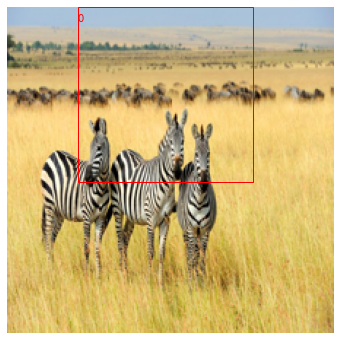

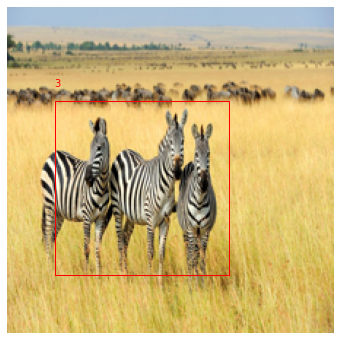

In [89]:
if model.kwargs['VISUALIZE']:
    model.visualize_preds(orig, nms_labels)